<a href="https://colab.research.google.com/github/KayvanShah1/usc-dsci560-dspp-sp24/blob/main/lab3-part2/notebooks/Apple_Inc_(AAPL)_Stock_Price_Forecast_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
from datetime import datetime, timedelta
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

warnings.filterwarnings("ignore")

# Data Extraction

In [ ]:
def get_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    if start_date is not None:
        data = pdr.get_data_yahoo(ticker_code, start=start_date, end=end_date)
    else:
        data = pdr.get_data_yahoo(ticker_code, end=end_date)
    return data


def clean_ticker_data(df):
    df = df.reset_index()
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values(by="date", ascending=True)
    df.rename(columns={"date": "datetime"}, inplace=True)
    return df


def resample(df):
    df = df.set_index("datetime")
    df = df.resample("D").asfreq()
    return df


def basic_preprocess(df):
    df = df.astype("float64")
    df = df.interpolate(method="time")
    df = df.fillna("bfill")
    return df.reset_index()


def prepare_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    df = get_ticker_data(ticker_code, start_date=start_date, end_date=end_date)
    df = clean_ticker_data(df)
    df = resample(df)
    df = basic_preprocess(df)
    return df

In [ ]:
stock_data = prepare_ticker_data("AAPL", start_date="2004-06-01")
stock_data.to_csv("AAPL_daily.csv", index=False)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
aapl_daily = pd.read_csv("AAPL_daily.csv")
aapl_daily

,datetime,open,high,low,close,adj_close,volume
0,2004-06-01,0.496250,0.503571,0.493036,0.501071,0.424748,1.821344e+08
1,2004-06-02,0.500536,0.520893,0.496429,0.516429,0.437766,3.187128e+08
2,2004-06-03,0.512857,0.517679,0.505179,0.507143,0.429895,2.509304e+08
3,2004-06-04,0.510000,0.522321,0.509107,0.513929,0.435647,3.991120e+08
4,2004-06-05,0.512857,0.526666,0.510893,0.520060,0.440844,3.647000e+08
...,...,...,...,...,...,...,...
7185,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.850006,1.025180e+08
7186,2024-02-03,182.623332,187.970001,181.446665,186.460002,186.460002,9.156827e+07
7187,2024-02-04,185.386663,188.610001,183.643331,187.069997,187.069997,8.061853e+07
7188,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.679993,6.966880e+07


# Data Processing

In [ ]:
# Calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    exp1 = df["close"].ewm(span=short_window, adjust=False).mean()
    exp2 = df["close"].ewm(span=long_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    df["macd"] = macd
    df["macd_signal"] = signal
    return df

# Calculate RSI
def calculate_rsi(df, window=14):
    delta = df["close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df["rsi"] = 100 - (100 / (1 + rs))
    return df

# Function to find crossover points and label them as "Buy" or "Sell"
def find_crossover_points(df):
    crossover_points = []
    prev_crossover = None

    for i in range(1, len(df)):
        if df["macd"][i] > df["macd_signal"][i] and df["macd"][i - 1] <= df["macd_signal"][i - 1]:
            crossover_points.append(("Buy", df["datetime"][i]))
            prev_crossover = "Buy"
        elif df["macd"][i] < df["macd_signal"][i] and df["macd"][i - 1] >= df["macd_signal"][i - 1]:
            crossover_points.append(("Sell", df["datetime"][i]))
            prev_crossover = "Sell"
        else:
            if prev_crossover is not None:
                crossover_points.append((prev_crossover, df["datetime"][i]))

    return crossover_points


def find_crossover_points_mod(df):
    crossover_points = ["No Action"]
    prev_crossover = None

    for i in range(1, len(df)):
        if (df["macd"][i] > df["macd_signal"][i] and df["macd"][i - 1] <= df["macd_signal"][i - 1]) or \
           (df["macd"][i] < df["macd_signal"][i] and df["macd"][i - 1] >= df["macd_signal"][i - 1]):
            crossover_points.append("Buy" if df["macd"][i] > df["macd_signal"][i] else "Sell")
            prev_crossover = "Buy" if df["macd"][i] > df["macd_signal"][i] else "Sell"
        else:
            if prev_crossover is not None:
                crossover_points.append(prev_crossover)
            else:
                crossover_points.append("No Action")

    return crossover_points

In [ ]:
df = pd.read_csv(
    "AAPL_daily.csv",
    usecols=["datetime", "close"]
)
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["day_of_week"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["day_of_year"] = df["datetime"].dt.dayofyear
df["quarter"] = df["datetime"].dt.quarter

df = calculate_macd(df, short_window=12, long_window=26, signal_window=10)
df = calculate_rsi(df)
df.dropna(inplace=True)

df

,datetime,close,day_of_week,month,year,day_of_year,quarter,macd,macd_signal,rsi
13,2004-06-14,0.537857,0,6,2004,166,2,0.010940,0.008615,72.198256
14,2004-06-15,0.548036,1,6,2004,167,2,0.011299,0.009103,75.239990
15,2004-06-16,0.584643,2,6,2004,168,2,0.014372,0.010061,79.843580
16,2004-06-17,0.585893,3,6,2004,169,2,0.016716,0.011271,87.058848
17,2004-06-18,0.587679,4,6,2004,170,2,0.018504,0.012586,86.419787
...,...,...,...,...,...,...,...,...,...,...
7185,2024-02-02,185.850006,4,2,2024,33,1,-0.265582,0.460091,34.023523
7186,2024-02-03,186.460002,5,2,2024,34,1,-0.446990,0.295168,33.402373
7187,2024-02-04,187.069997,6,2,2024,35,1,-0.535364,0.144162,32.769416
7188,2024-02-05,187.679993,0,2,2024,36,1,-0.549841,0.017980,32.124312


## Scaling

In [ ]:
features_to_be_scaled = ["day_of_week", "month", "year", "day_of_year", "quarter", "macd", "macd_signal", "rsi"]
predicate_scaler = ["close"]

In [ ]:
# Feature scaler
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df[features_to_be_scaled])
df[[f"scaled_{i}" for i in features_to_be_scaled]] = scaled_features

# Prediction scaler
prediction_scaler = MinMaxScaler()
scaled_predictions = prediction_scaler.fit_transform(df[predicate_scaler])
df[[f"scaled_{i}" for i in predicate_scaler]] = scaled_predictions

df

,datetime,close,day_of_week,month,year,day_of_year,quarter,macd,macd_signal,rsi,scaled_day_of_week,scaled_month,scaled_year,scaled_day_of_year,scaled_quarter,scaled_macd,scaled_macd_signal,scaled_rsi,scaled_close
13,2004-06-14,0.537857,0,6,2004,166,2,0.010940,0.008615,72.198256,0.000000,0.454545,0.0,0.452055,0.333333,0.502483,0.483597,0.718486,0.000089
14,2004-06-15,0.548036,1,6,2004,167,2,0.011299,0.009103,75.239990,0.166667,0.454545,0.0,0.454795,0.333333,0.502514,0.483643,0.749286,0.000140
15,2004-06-16,0.584643,2,6,2004,168,2,0.014372,0.010061,79.843580,0.333333,0.454545,0.0,0.457534,0.333333,0.502779,0.483733,0.795900,0.000325
16,2004-06-17,0.585893,3,6,2004,169,2,0.016716,0.011271,87.058848,0.500000,0.454545,0.0,0.460274,0.333333,0.502981,0.483848,0.868961,0.000332
17,2004-06-18,0.587679,4,6,2004,170,2,0.018504,0.012586,86.419787,0.666667,0.454545,0.0,0.463014,0.333333,0.503135,0.483972,0.862490,0.000341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7185,2024-02-02,185.850006,4,2,2024,33,1,-0.265582,0.460091,34.023523,0.666667,0.090909,1.0,0.087671,0.000000,0.478674,0.526217,0.331937,0.937952
7186,2024-02-03,186.460002,5,2,2024,34,1,-0.446990,0.295168,33.402373,0.833333,0.090909,1.0,0.090411,0.000000,0.463055,0.510648,0.325647,0.941039
7187,2024-02-04,187.069997,6,2,2024,35,1,-0.535364,0.144162,32.769416,1.000000,0.090909,1.0,0.093151,0.000000,0.455446,0.496393,0.319238,0.944127
7188,2024-02-05,187.679993,0,2,2024,36,1,-0.549841,0.017980,32.124312,0.000000,0.090909,1.0,0.095890,0.000000,0.454200,0.484481,0.312706,0.947214


## Subset

In [ ]:
# Select a subset of data for plotting (for example, first 100 data points)
subset_df = df.tail(500).reset_index()
subset_df.drop(columns=["index"], inplace=True)

subset_df

,datetime,close,day_of_week,month,year,day_of_year,quarter,macd,macd_signal,rsi,scaled_day_of_week,scaled_month,scaled_year,scaled_day_of_year,scaled_quarter,scaled_macd,scaled_macd_signal,scaled_rsi,scaled_close
0,2022-09-25,150.656667,6,9,2022,268,3,-2.421713,-2.240654,32.421548,1.000000,0.727273,0.9,0.731507,0.666667,0.293029,0.271262,0.315715,0.759839
1,2022-09-26,150.770004,0,9,2022,269,3,-2.424636,-2.274105,27.928897,0.000000,0.727273,0.9,0.734247,0.666667,0.292778,0.268104,0.270224,0.760413
2,2022-09-27,151.759995,1,9,2022,270,3,-2.320320,-2.282508,44.820713,0.166667,0.727273,0.9,0.736986,0.666667,0.301759,0.267311,0.441267,0.765423
3,2022-09-28,149.839996,2,9,2022,271,3,-2.365312,-2.297563,36.678028,0.333333,0.727273,0.9,0.739726,0.666667,0.297885,0.265890,0.358815,0.755706
4,2022-09-29,142.479996,3,9,2022,272,3,-2.960729,-2.418139,30.180360,0.500000,0.727273,0.9,0.742466,0.666667,0.246619,0.254507,0.293022,0.718457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2024-02-02,185.850006,4,2,2024,33,1,-0.265582,0.460091,34.023523,0.666667,0.090909,1.0,0.087671,0.000000,0.478674,0.526217,0.331937,0.937952
496,2024-02-03,186.460002,5,2,2024,34,1,-0.446990,0.295168,33.402373,0.833333,0.090909,1.0,0.090411,0.000000,0.463055,0.510648,0.325647,0.941039
497,2024-02-04,187.069997,6,2,2024,35,1,-0.535364,0.144162,32.769416,1.000000,0.090909,1.0,0.093151,0.000000,0.455446,0.496393,0.319238,0.944127
498,2024-02-05,187.679993,0,2,2024,36,1,-0.549841,0.017980,32.124312,0.000000,0.090909,1.0,0.095890,0.000000,0.454200,0.484481,0.312706,0.947214


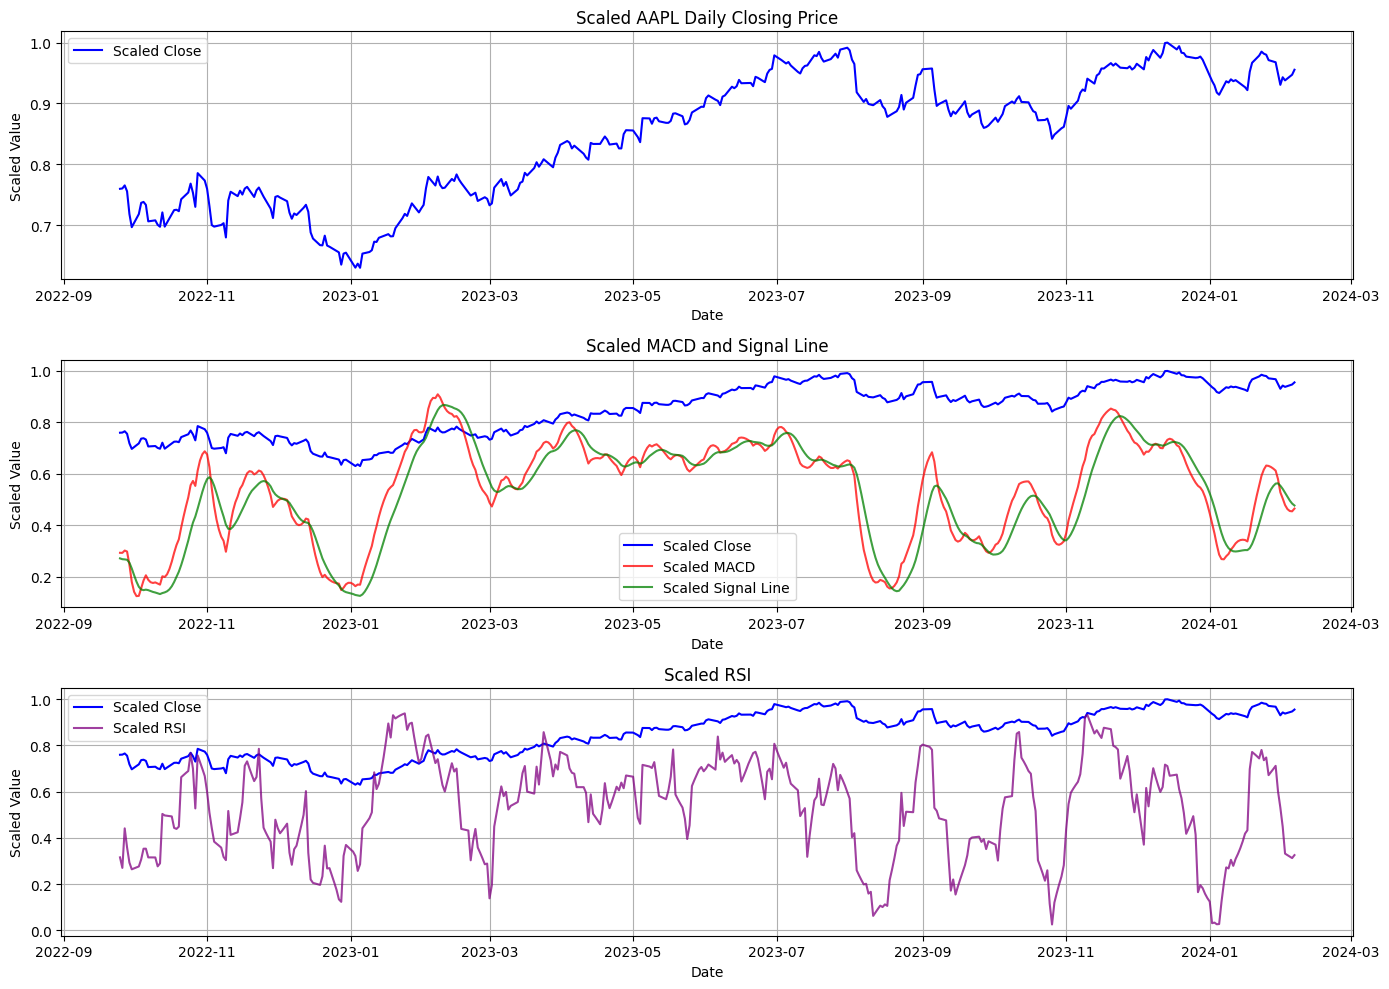

In [ ]:
# Plotting
plt.figure(figsize=(14, 10))

# Closing price subplot
plt.subplot(3, 1, 1)
plt.plot(subset_df["datetime"], subset_df["scaled_close"], label="Scaled Close", color="blue")
plt.title("Scaled AAPL Daily Closing Price")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

# MACD subplot
plt.subplot(3, 1, 2)
plt.plot(subset_df["datetime"], subset_df["scaled_close"], label="Scaled Close", color="blue")
plt.plot(subset_df["datetime"], subset_df["scaled_macd"], label="Scaled MACD", color="red", alpha=0.75)
plt.plot(subset_df["datetime"], subset_df["scaled_macd_signal"], label="Scaled Signal Line", color="green", alpha=0.75)
plt.title("Scaled MACD and Signal Line")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

# RSI subplot
plt.subplot(3, 1, 3)
plt.plot(subset_df["datetime"], subset_df["scaled_close"], label="Scaled Close", color="blue")
plt.plot(subset_df["datetime"], subset_df["scaled_rsi"], label="Scaled RSI", color="purple", alpha=0.75)
plt.title("Scaled RSI")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Correlation Analysis

Based on the correlation matrix and your specific objectives, you might consider the following features:

1. **Close Price (`close`)**: This is the target variable you want to predict. It has moderate correlations with `year` and `macd_signal`, indicating their potential predictive power.

2. **MACD and MACD Signal (`macd`, `macd_signal`)**: These technical indicators have moderate correlations with the close price, suggesting they might be useful predictors. Additionally, they show a strong correlation with each other, which can be helpful for feature engineering or model selection.

3. **Year (`year`)**: The year has a moderate correlation with the close price, indicating a potential trend over time. Including this feature might capture long-term trends in the stock price.

4. **RSI (`rsi`)**: The Relative Strength Index has a weak positive correlation with the close price and moderate correlations with MACD and MACD Signal. While its correlation is weaker compared to other features, it might still provide valuable information for prediction.

5. **Day of Week (`day_of_week`)** and **Month (`month`)**: These date-related features have very weak correlations with the close price. However, they might still capture seasonal patterns or behavioral trends in trading, so it could be worth experimenting with them.

You may start with these features and iteratively refine your model based on performance metrics such as accuracy, precision, recall, or Mean Squared Error (MSE). Additionally, consider incorporating domain knowledge or experimenting with feature engineering techniques to further improve predictive performance.

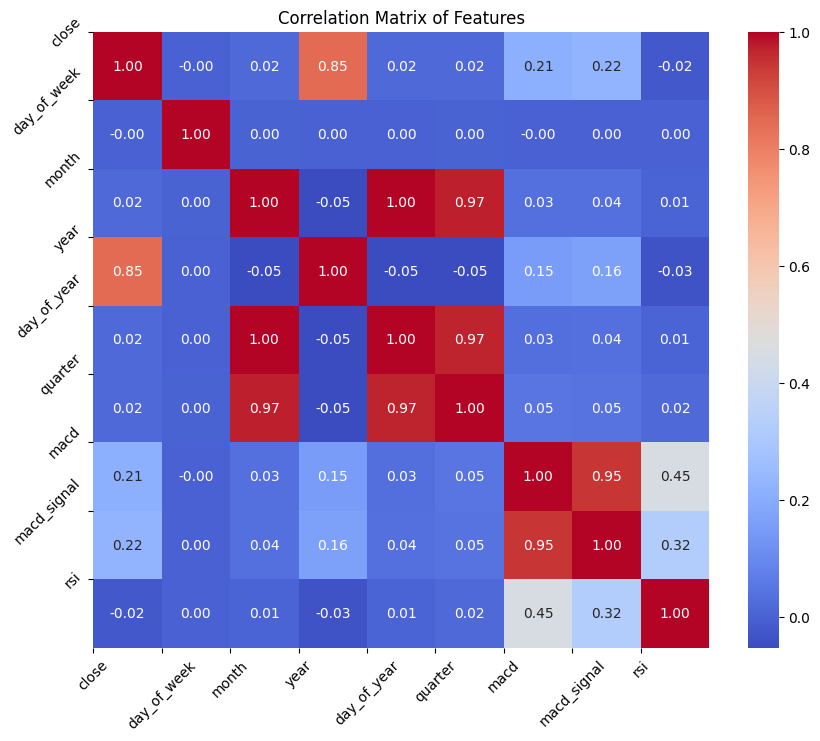

In [ ]:
# Correlation analysis
correlation_matrix = df[["close", "day_of_week", "month", "year", "day_of_year", "quarter", "macd", "macd_signal", "rsi"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title('Correlation Matrix of Features')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.show()


1. **Autocorrelation Function (ACF)**:
   - The ACF at lag 0 is always 1 because it represents the correlation of the series with itself.
   - Look for significant spikes in the ACF plot. Significant spikes are those that extend beyond the blue shaded region, indicating potential correlations.
   - In your ACF values, you can see that the autocorrelation remains high (close to 1) for many lags, which suggests strong autocorrelation. However, it starts to decrease gradually.
   - Significant autocorrelation is observed up to lag 2. After that, it starts to decrease, but there are still some significant values up to lag 10.
   - You can consider using lags 1 and 2 as they have high autocorrelation values. Beyond that, you might consider lags up to 10 if you want to capture more autocorrelation.

2. **Partial Autocorrelation Function (PACF)**:
   - The PACF at lag 0 is always 1 because it represents the correlation of the series with itself.
   - Look for significant spikes in the PACF plot. Similar to the ACF plot, significant spikes are those that extend beyond the blue shaded region.
   - In your PACF values, you can see that the partial autocorrelation remains high (close to 1) for the first few lags, and then it starts to drop off.
   - Significant partial autocorrelation is observed up to lag 2. After that, it becomes close to zero, indicating that the autocorrelation is being explained by the previous lags.
   - Therefore, you can consider using lags 1 and 2 based on the PACF.

Based on the analysis of both ACF and PACF, you can consider using lags 1 and 2 for modeling the autocorrelation in your data. However, depending on your specific analysis and model requirements, you may choose to include more lags.

In [ ]:
# # Compute ACF and PACF values
# acf_values = acf(close_series, nlags=30)
# pacf_values = pacf(close_series, nlags=30)

# list(zip(acf_values, pacf_values))

In [ ]:
# Prepare Data
close_series = df["close"]

# Compute ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(close_series, lags=30, ax=plt.gca(), title="Autocorrelation Function (ACF)")
plt.subplot(2, 1, 2)
plot_pacf(close_series, lags=30, ax=plt.gca(), title="Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

## Lag Analysis

In [ ]:
# Add lag features up to 5 lags
def add_lags(df, n):
    for i in range(1, n+1):
        df[f'lag_{i}_scaled_close'] = df['scaled_close'].shift(i)
    df.dropna(inplace=True)
    return df

# Drop NaN values
lagged_df = df.copy(deep=True)
lagged_df = add_lags(lagged_df, 5)

sel_cols = [
    'datetime',
    'scaled_day_of_week', 'scaled_month', 'scaled_year', 'scaled_day_of_year', 'scaled_quarter',
    'scaled_macd', 'scaled_macd_signal', 'scaled_rsi',
    'scaled_close',
    'lag_1_scaled_close', 'lag_2_scaled_close', 'lag_3_scaled_close', 'lag_4_scaled_close', 'lag_5_scaled_close'
]

lagged_df = lagged_df.loc[:, sel_cols]
lagged_df

In [ ]:
# Define the ratio for train-test split
train_ratio = 0.9
test_ratio = 1 - train_ratio

# Calculate the index for splitting the data
split_index = int(train_ratio * len(lagged_df))

# Split the data into train and test sets
train_data = lagged_df.iloc[:split_index]
test_data = lagged_df.iloc[split_index:]

# Separate the features (X) and target (y) variables
X_train = train_data.drop(columns=['datetime', 'scaled_close'])
y_train = train_data['scaled_close']

X_test = test_data.drop(columns=['datetime', 'scaled_close'])
y_test = test_data['scaled_close']

In [ ]:
# Plot train and test data
plt.figure(figsize=(20, 7))
plt.plot(train_data['datetime'], train_data['scaled_close'], label='Train', color='blue')
# plt.plot(valid_data['datetime'], valid_data['scaled_close'], label='Valid', color='orange')
plt.plot(test_data['datetime'], test_data['scaled_close'], label='Test', color='red')

plt.title('Apple Inc. (AAPL) train, valid & test splits')
plt.xlabel('Date')
plt.ylabel('Scaled Close')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_valid = X_valid.values.reshape(X_valid.shape[0], 1, X_valid.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

In [ ]:
# 6. Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

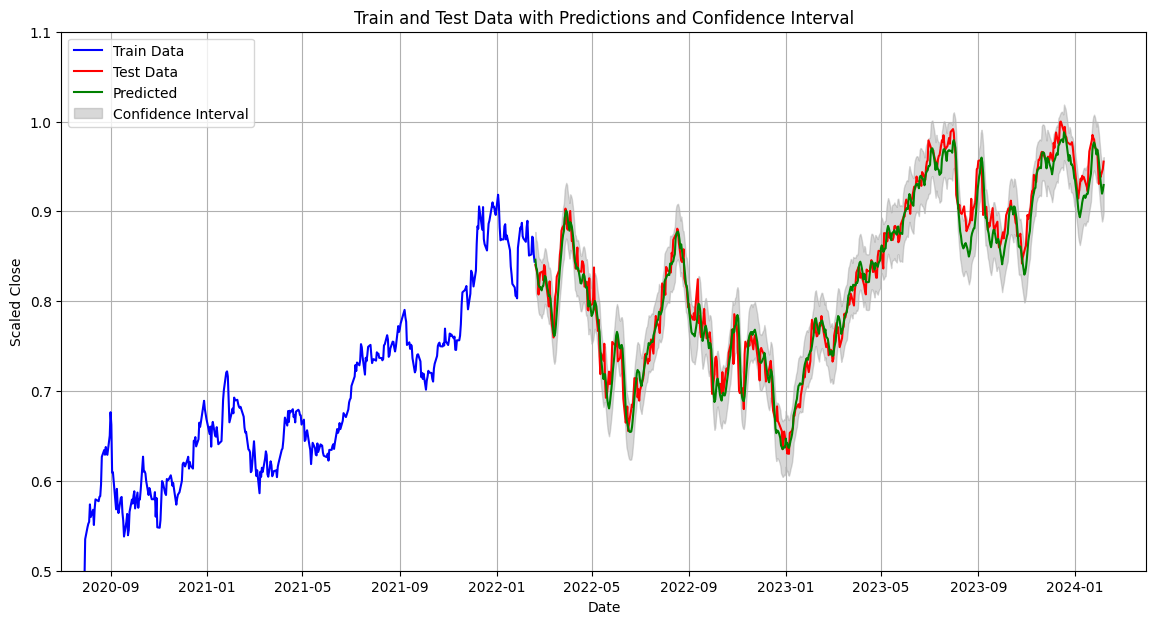

In [ ]:
# Calculate residuals
residuals = y_test - y_pred.reshape(-1)

# Compute standard deviation of residuals
std_dev = np.std(residuals)

# Calculate confidence intervals
confidence_interval = 1.96 * std_dev  # 95% confidence interval

# Plotting
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_data['datetime'], train_data['scaled_close'], label='Train Data', color='blue')

# Plot test data
plt.plot(test_data['datetime'], test_data['scaled_close'], label='Test Data', color='red')

# Plot predicted values
plt.plot(test_data['datetime'], y_pred, label='Predicted', color='green')

# Compute upper and lower bounds for confidence interval
upper_bound = y_pred + confidence_interval
lower_bound = y_pred - confidence_interval

# # Plot confidence interval
plt.fill_between(test_data['datetime'], upper_bound.flatten(), lower_bound.flatten(), color='gray', alpha=0.3, label='Confidence Interval')

# Set x-axis limits
plt.xlim(pd.Timestamp('2020-07-01'), pd.Timestamp('2024-03-31'))
# Set y-axis limits
plt.ylim(0.5, 1.1)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Close')
plt.title('Train and Test Data with Predictions and Confidence Interval')
plt.legend()
plt.grid(True)

# Show plot
plt.show()